# Project 2: Regression for Prediction Problems
Team members: Hero Ashman, Madeleine Parker, Elleni Hailu, Yael Nidam.

This reports outlines the steps to explore and analyze goverment data to better understand the prevelance of diabetes in Alabama, and ultimately inform decisions about where to target a pilot diabetes prevention program.

We use data from the Center for Disease Control and Prevention (CDC) and the US Census Bureau American Community Survey (ACS) to predict diabetes rates at the county level.

#### Report overview:

1. Data cleaning
2. Exploratory data analysis.
3. Data perperation for machnine learning models.
4. Train 5 Machine learning models.
5. Validate and refine models.
6. Discussion


## 1. Data Cleaning

### 1.1 Import libraries and explore data shape

In [38]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [39]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv")
diabetes.head(3)

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,1001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,1003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,1005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630


In [40]:
# number of rows and columns
diabetes.shape

(3220, 95)

In [169]:
#View all column names
#cols = diabetes.columns.tolist()
#cols
#for i in range(len(cols)):
#    print(i,cols[i])

#[diabetes.columns.get_loc(c) for c in cols if c in diabetes]

# list of variable names (long)
#list(diabetes.columns.values)

### 1.2 Ensure that all datatypes other than the counry and state names are numeric.

In [42]:
#Checkout all datatypes that are object
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females)
0,Autauga County,Alabama,5178,13489,12525,76.5
1,Baldwin County,Alabama,16707,48542,40024,86.6
2,Barbour County,Alabama,3400,8009,5431,76.2


The counts for diabetes, people who are obese, people who are inactive, and the male to female sex ratio for people over aged 65 years old are strings. Some of these columns contain missing data, which is recorded as the string "No Data". We convert these columns to floats, coercing any rows with non-numeric strings in to NaN.  

In [43]:
diabetes['Diabetes_Number'] = pd.to_numeric(arg=diabetes['Diabetes_Number'], errors='coerce')
diabetes['Obesity_Number'] = pd.to_numeric(arg=diabetes['Obesity_Number'], errors='coerce')
diabetes['Physical_Inactivity_Number'] = pd.to_numeric(arg=diabetes['Physical_Inactivity_Number'], errors='coerce')
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = pd.to_numeric(arg=diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'], errors='coerce')

#using the same command to check there are no obtect type columns
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State
0,Autauga County,Alabama
1,Baldwin County,Alabama
2,Barbour County,Alabama


### 1.3 Check missing counts for key variables

In [44]:
print(diabetes.isnull().sum().sum())
diabetes.columns[diabetes.isnull().any()]


186


Index(['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)'],
      dtype='object')

In total, there are 186 missing values in our data. Predictors with missing values are diabetes_number, obesisty_number, physical_inactivity_number, and sex_ratio_over_65. There is 1 row with missing diabetes counts. There are 78 rows with missing counts for Physically Inactive and Obese. There are 29 missing values for the sex ratio over 65yrs old. 

In [45]:
diabetes.isnull().sum()[3:7]
#diabetes = diabetes.dropna(subset=['Diabetes_Number'])
#diabetes.shape


Diabetes_Number                                                                      1
Obesity_Number                                                                      78
Physical_Inactivity_Number                                                          78
sex and age_total population_65 years and over_sex ratio (males per 100 females)    29
dtype: int64

## 2. Exploratory Data Analysis
Our data set is a combination of variables from the CDC and the ACS at the county level. We have information from 3220 counties. Variables include the population counts of people with diabetes, who are obese, and who are physically inactive, and population counts of people by race, ethnicity, age, and sex. 

**Distribution of Diabetes Cases** 

We start our report with some descriptive plots. Our goal here is to explore variation in diabetes numbers across counties. We also look at a couple of predictors that we suspect might be important for prediction later on.  

We plot a histogram of diabetes cases as the county level. We plot this both as number of cases and as number of cases per 100 people, as the counties vary in population size. 

In [46]:
# calculate diabetes cases per 100 people
diabetes['diabetes_per100'] = diabetes['Diabetes_Number']/diabetes['race_total population']*100

# calculate log of diabetes cases
diabetes['ln_diabetes'] = np.log(diabetes["Diabetes_Number"])

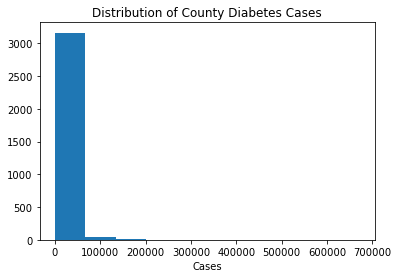

In [47]:
#diabetes cases across counties
#sns.histplot(data = diabetes, x = 'Diabetes_Number')
plt.hist(diabetes['Diabetes_Number'])
plt.title("Distribution of County Diabetes Cases")
plt.xlabel("Cases");

The plot above shows that the distribution of cases across counties is extremely right skewed, likely driven by counties with very large populations. Logging the case numbers makes the distribution easier to see. 

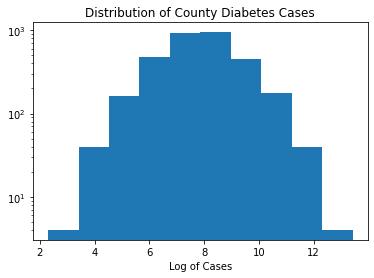

In [48]:
#sns.histplot(data = diabetes, x = 'Diabetes_Number', log_scale= True)
plt.hist(diabetes['ln_diabetes'], log = True)
plt.title("Distribution of County Diabetes Cases")
plt.xlabel("Log of Cases");

The plot below shows that the percentage of people with diabetes is roughly normally distributed across counties, with a mean around 10%. This corresponds to the percentage of the population with diabetes reported by the [American Diabetes Association](https://www.diabetes.org/resources/statistics/statistics-about-diabetes). 

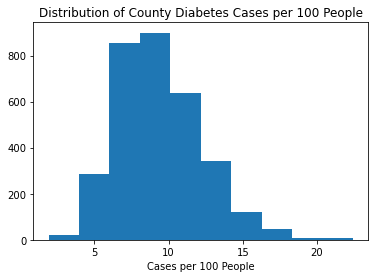

In [49]:
# diabetes per 100 people
#sns.histplot(data = diabetes, x = 'diabetes_per100', kde = True)
plt.hist(diabetes["diabetes_per100"])
plt.title("Distribution of County Diabetes Cases per 100 People")
plt.xlabel("Cases per 100 People");

**Diabetes and Level of Inactivity**

We suspect there might be a relationship between diabetes and level of inactivity. To explore this, we plot the linear regression line of physical inactivity on diabetes cases, at the county level. We first log both numbers. The plot below also includes a scatter plot of the underlying data. There is a linear relationship between number of diabetes cases and number of people who are physically inactive. There is greater variation around the middle of the distribution. This implies that the number of inactive people might not be a good linear predictor for the number of diabetes cases in counties with cases around the middle of the distribution. 

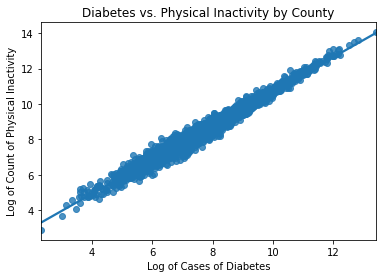

In [50]:
# take log of physically inactive
diabetes['ln_inactive'] = np.log(diabetes["Physical_Inactivity_Number"])

sns.regplot(data = diabetes, x = 'ln_diabetes', y = 'ln_inactive', scatter = True)
plt.title("Diabetes vs. Physical Inactivity by County")
plt.xlabel("Log of Cases of Diabetes")
plt.ylabel("Log of Count of Physical Inactivity");

There is similarly a linear relationship between diabetes cases and the number of obese people at the county level. Again, this relationship seems weakest around the middle of the distribution, where there is greater variation, and it is not clear that increasing cases of obesity would predict increasing cases of diabetes. 

__Diabetes and obesity__

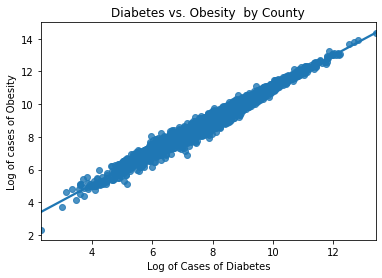

In [51]:
# Diabetes and obesity
diabetes['ln_obesity'] = np.log(diabetes["Obesity_Number"])

sns.regplot(data = diabetes, x = 'ln_diabetes', y = 'ln_obesity', scatter = True)
plt.title("Diabetes vs. Obesity  by County")
plt.xlabel("Log of Cases of Diabetes")
plt.ylabel("Log of cases of Obesity");

**Diabetes and Demographic Characteristics**

Our data contains county population counts by sex, race, and age (and interactions of all three). It is possible that upstream social factors that vary by gender, such as diet or activity levels, impact rates of diabetes. Although we do not observe the rates of diabetes differentially for men and women (the only genders reported in the ACS), we can see if counties with a higher male to female ratio have higher or lower rates of diabetes. For this, we create a dummy variable indicating if a county has more or equal number of women than men (female_cnty). We then plot a box-and-whisker diagram of cases per 100 people for the two types of county.

The plot below shows that for counties with equal or higher numbers of women than men, their rate of diabetes is slightly higher (orange plot). However, there is not a large difference and it may not be significant.  


In [52]:
# dummy for a county having more or equal number of women to men
diabetes['female_cnty'] = 1*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] <=100) \
+ 0*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] > 100)
#diabetes['female_cnty']

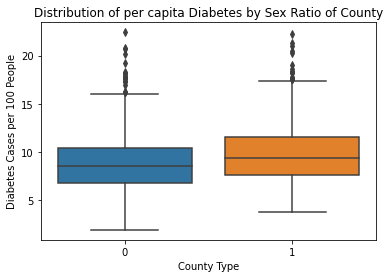

In [53]:
sns.boxplot(data = diabetes, x = 'female_cnty', y = 'diabetes_per100')
plt.title('Distribution of per capita Diabetes by Sex Ratio of County')
plt.xlabel('County Type')
plt.ylabel('Diabetes Cases per 100 People');

## 3. Data perperation for machine learning models.

In this next section we prepare the data so we can use it to fir machine learning models. Our process includes additional data cleaning steps, data partition, and preliminary feature selection.

### 3.1 Additional Data Cleaning

We remove geographic features and variables we created for data exploration.

In [92]:
# We create a new variable to store the clean dataset
diabetes_clean = diabetes 

# We drop variables that shouldn't be used in the analysis
diabetes_clean = diabetes_clean.drop([ 'State' ,'County','CountyFIPS' # columns with geographic information
                                       ,'diabetes_per100','ln_diabetes','ln_inactive','ln_obesity','female_cnty' #Data exploration variables
                                     ], axis=1)
diabetes_clean.shape

(3220, 92)

We remove all rows with missing values. 

In [93]:
#Remove all rows with missing values
diabetes_clean = diabetes_clean.dropna()
diabetes_clean.shape

(3112, 92)

We also create a binary variable for high diabetes cases indicator based on median split and separating the response from the features:

In [94]:
# create a binary variable for logistic regression
# diabetes_clean.describe() #median of Diabetes counts is 2609 [high diabetes: >2609 and low diabetes <=2609]
diabetes_clean.loc[diabetes_clean['Diabetes_Number'] < 2609, 'diabetes_cat'] = "< 2609"
diabetes_clean.loc[diabetes_clean['Diabetes_Number'] >= 2609, 'diabetes_cat'] = ">= 2609"
#diabetes_clean.head()


In [95]:
from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
diabetes_clean['diabetes_binary'] = lb_style.fit_transform(diabetes_clean["diabetes_cat"])
#diabetes_clean.head(10)

### 3.2 Feature Selection

We examine the correlation of the sociodemographic variables included in the sample and select only ones with low correltation with one another. Because much of the variables in regards to the racial composition and the sex distribution in the counties are related, not doing so will lead our models to not converge. Hence, driven both by prior literature/theory and the correlation of these variables in our dataset, we select obesity and physical activity counts, the distribution of each broadly defined racial group (white, Black/African American, American Indian/Aaska Native, Native Hawaiian/Pacific Islander, and Hispanic/Latino), eligible voters, the sex ratio of the entire population, and total housing units in each county. Although limited, we believe these features will allow us to estimate the influence of historical and institutional practices that continue to disproportionately burden marginalized populations around the country, while using physical inactivity and obesity counts as a proxy to account for the availablility of health promoting resources. Total housing is potentially a proxy for wealth. 

There are various variables reporting counts of people by race. We use the "race alone or in combination with one or more other races", which includes in each category people who report one or more race. These categories sum together to the total population. We exclude the category "other race". We convert each of the race count variables to percentages, so that rather than capturing the count of people of a given race, we capture the distribution of people across different races. This controls for the fact that counties vary in population size. 

Q: should we have county population size as a predictor?

In [133]:
#cols = diabetes_clean.columns.tolist()
#cols
# list of variable names (long)
#list(diabetes_clean.columns.values)


In [134]:
#pd.set_option('display.max_rows', None)
#diabetes_clean.corr()
#diabetes_clean.corr()['race_total population']
#diabetes_clean.corr()['total housing units']
#diabetes_clean.corr()['race alone or in combination with one or more other races_total population_white']
#diabetes_clean.corr()['race_total population_one race_white']
#diabetes_clean.corr()['race_total population_one race_black or african american']
#diabetes_clean.corr()['race_total population_one race_american indian and alaska native']
#diabetes_clean.corr()['race_total population_one race_asian']
#diabetes_clean.corr()['citizen -  voting age population_citizen -  18 and over population']
#diabetes_clean.corr()['sex and age_total population_sex ratio (males per 100 females)]

In [121]:
#View all column names
#cols = diabetes_clean.columns.tolist()
#cols
#for i in range(len(cols)):
#    print(i,cols[i])

In [140]:
# WARNING: if the indexing of diabetes_clean changes above, these calculations will be wrong

# convert count variables to percents
diabetes_clean[['pct_white']] = diabetes_clean.iloc[:,35]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_black']] = diabetes_clean.iloc[:,36]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_native']] = diabetes_clean.iloc[:,37]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_asian']] = diabetes_clean.iloc[:,38]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_pacisl']] = diabetes_clean.iloc[:,39]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_other']] = diabetes_clean.iloc[:,40]/diabetes_clean.iloc[:,34]
diabetes_clean[['pct_hispan']] = diabetes_clean['hispanic or latino and race_total population_hispanic or latino (of any race)']/diabetes_clean['hispanic or latino and race_total population']

diabetes_clean.iloc[:,94:101].head()


,pct_white,pct_black,pct_native,pct_asian,pct_pacisl,pct_other,pct_hispan
0,0.785634,0.198587,0.008406,0.016214,0.002083,0.007736,0.027681
1,0.877861,0.097599,0.015305,0.013570,0.000380,0.012724,0.044943
2,0.483322,0.484524,0.011675,0.006012,0.000039,0.031029,0.042898
3,0.774493,0.227150,0.003995,0.002264,0.000000,0.000400,0.024282
4,0.971134,0.019499,0.012386,0.005065,0.000919,0.008309,0.091266


In [154]:
# rename variables for ease
diabetes_clean = diabetes_clean.rename(columns={"citizen -  voting age population_citizen -  18 and over population": "citizen", "sex and age_total population_sex ratio (males per 100 females)": "sex_ratio"})

X = diabetes_clean[['Obesity_Number',
                    'Physical_Inactivity_Number',
                    'pct_white',
                    'pct_black',
                    'pct_native',
                    'pct_asian',
                    'pct_pacisl',
                    'pct_hispan',
                    'total housing units',
                    'citizen',
                    'sex_ratio' ]]
Y =diabetes_clean['Diabetes_Number'] # for all other models
Y1 = diabetes_clean['diabetes_binary'] # for logistic regression


### 3.3 Partition Data

#### Training Set

Since our dataset is small, we are interested in saving a relatively large portion (40%) of it for the test dataset, so that we can reduce overfitting. **This no longer holds - we need a justification for using the 60:20:20 split** 

In [155]:
from sklearn.model_selection import train_test_split

# set the random seed to ensure that results are similar across different runs and machines. 
np.random.seed(10)

# split the data 4 ways:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.80, test_size=0.20)

In [156]:
# for logistic regression splitting the data 4 ways
np.random.seed(10)

# split the data 4 ways:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y1,
                                                    train_size=0.80, test_size=0.20)

In [151]:
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)
print("Shape of y_train1 is", y_train.shape)
print("Shape of y_test1 is", y_test.shape)

Shape of X train is (1866, 11)
Shape of y_train is (1866,)
Shape of X_test is (623, 11)
Shape of y_test is (623,)
Shape of y_train1 is (1866,)
Shape of y_test1 is (623,)


#### Validation Set

In order to tune our hyperparamters, we also set aside a validation data set from the training data. We subset 75% of our training data as validaton data. This gives a total split of training:validation:test as 60:20:20. 

In [157]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [158]:
# validation set for logistic regression
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X_train1, y_train1,
                                                    train_size=0.75, test_size=0.25)

In [147]:
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)
print("Shape of y_train is", y_train1.shape)
print("Shape of y_validate is", y_validate1.shape)

Shape of X train is (1866, 11)
Shape of y_train is (1866,)
Shape of X_validate is (623, 11)
Shape of y_validate is (623,)
Shape of y_train is (1866,)
Shape of y_validate is (623,)


## 4. Train Models

### 4.1 Model Descriptions

**paste in from google doc**

### 4.2 Train Models
0. Linear Regression
1. Logistic Regression
2. Random Forest
3. Ridge Regression
4. Lasso
5. Nearest neighbors

Below, we train each model on the training set and predict our outcome on the validation set. We then assess how well our models fit the validation data by reporting accuracy scores. Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

We ran into some issues with logistic regression not converging and the OLS coefficients being very large in magnitude due to different scales of the variables. We therefore scaled all our variables to be mean zero and unit standard deviation. This is a necessary prior step when running Ridge and Lasso too.  

#### 0. OLS

We start by running OLS.  

In [162]:
# create a model
lin_reg = LinearRegression()

# scale the data??
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)

# fit the model
lin_model = lin_reg.fit(X_scaled, y_train)

# look at the coefficients
print(lin_model.coef_)
print(lin_model.intercept_)


[  4392.19839826  12086.56937592   -303.49144553    -56.36179595
    -74.90361094   -682.26244762    485.57605029   -159.0714743
 -11224.37030069  20269.16837622    -66.19658265]
8374.691854233655


We want to see how well this model fits our data. Using the validation data, we predict our response variable and report the variation explained by the OLS model. We are able to explain 98% of the variation in our validation data. 

In [160]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

# predict on the validation data
y_pred = lin_model.predict(X_validate)

print("the explained variance is:", explained_variance_score(y_validate, y_pred))
print("the mean squred error is:", mean_squared_error(y_validate, y_pred)) 
# This seems insane!

the explained variance is: -27368315847.30019
the mean squred error is: 8.053917547433069e+18


We can also visualize the coefficients. The most important variable seems to be citizen, which is the population over the age of 18. This is essentially the size of the county (minus the children), which makes sense as to why it determines the number of diabetes. 

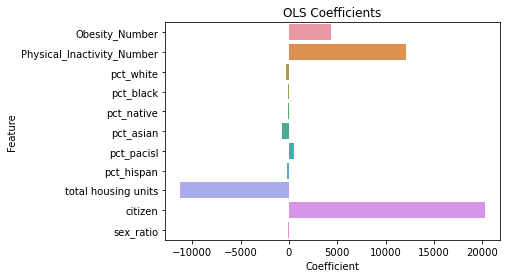

In [161]:
# Create a dataframe with the coefficient and feature names
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T
lin_reg_data.columns = ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(data = lin_reg_data, y = 'Feature', x = 'Coefficient')
ax.set_title("OLS Coefficients")
plt.show()

#### 2. Logistic Regression

In [82]:
# create a model
log_reg = LogisticRegression()

# fit the model
log_model = log_reg.fit(X_scaled, y_train1)

print(log_model.coef_)
print(log_model.intercept_)

[[ 5.96416846  6.50788015  5.11279246  3.84675092  0.43639876  0.16786956
   0.1296738   4.46596857  0.46016712  4.35706106 -0.14875131]]
[5.9806504]


Examine the coefficients via visualization

In [257]:
# Create a dataframe with the coefficient and feature names
log_reg_data = pd.DataFrame([log_model.coef_, X.columns]).T
log_reg_data.columns= ['Coefficient', 'Feature']
# Plot
#ax = sns.barplot(x="Coefficient", y="Feature", data=log_reg_data)
#ax.set_title("Logistic regression Coefficients")
#plt.show()

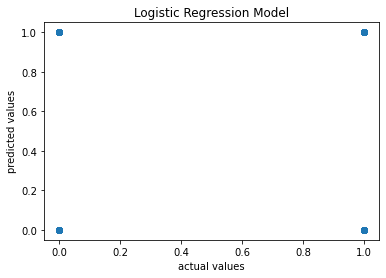

In [258]:
# use the model to make predictions
log_pred = log_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate1, log_pred)
plt.title('Logistic Regression Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 2. Random Forest

In [259]:
rand_for=RandomForestRegressor()
rand_model=rand_for.fit(X_train, y_train)
rand_for_data = pd.DataFrame([rand_model.estimators_, X.columns]).T
rand_for_data.columns = ['Estimator', 'Feature']


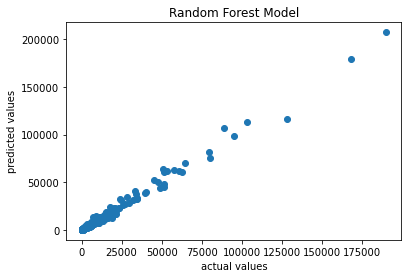

In [271]:
# use the model to make predictions
rand_pred = rand_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, rand_pred)
plt.title('Random Forest Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 3. Ridge Regression

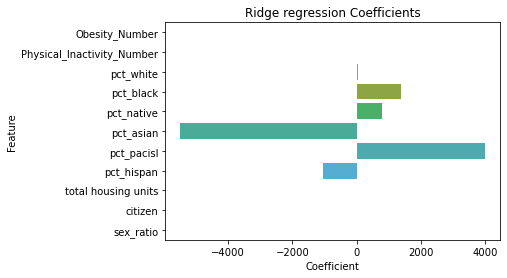

In [163]:
# make and fit a Ridge regression model
ridge_reg = Ridge() 
ridge_model = ridge_reg.fit(X_train, y_train)
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']
ridge_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data)
ax.set_title("Ridge regression Coefficients")
plt.show()

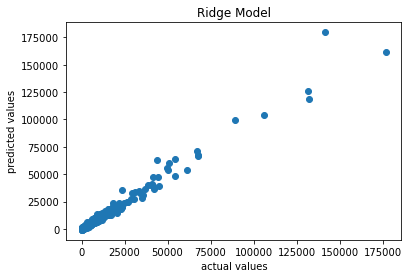

In [164]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 4. Lasso

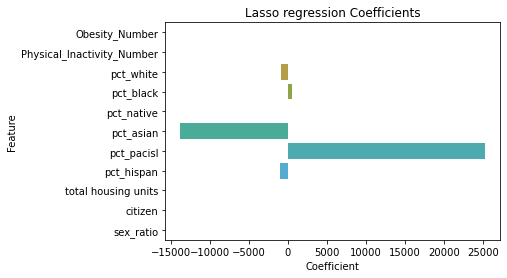

In [165]:
# create and fit the model
lasso_reg = Lasso(max_iter=10000)  
lasso_model = lasso_reg.fit(X_train, y_train)
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']
lasso_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data)
ax.set_title("Lasso regression Coefficients")
plt.show()


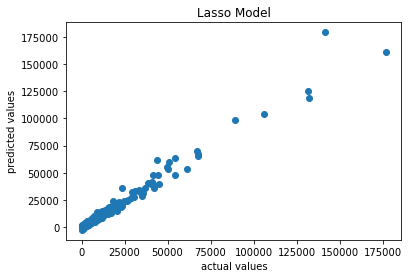

In [166]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)
plt.title('Lasso Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 5. Nearest neighbors

In [167]:
neigh_reg = KNeighborsRegressor(n_neighbors=2)
neigh_model=neigh_reg.fit(X_train, y_train)


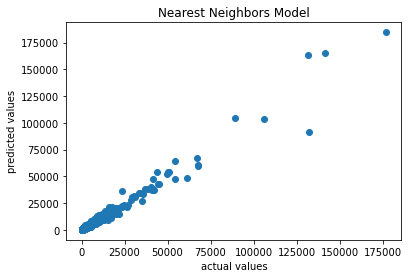

In [168]:
# use the model to make predictions
neigh_pred = neigh_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, neigh_pred)
plt.title('Nearest Neighbors Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

## 5. Validate and Refine Model

### 5.1 Predict on the Validation Set

### 5.2 Feature Selection

### 5.3 Evaluate performance of models on test set

### 5.4 Implement Cross validation

## 6. Discussion Questions